In [1]:
# %pip install opencv-python-headless selenium

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.heatmap_generator.heatmap import generate_dataset
from utils.heatmap_generator.background import CaptureWebsite

In [34]:
import matplotlib.pyplot as plt
import os
import random
import cv2

def show_image_with_boxes(image_path, label_path):
    """
    Load an image and its corresponding .txt labels, then display
    the image with bounding boxes overlaid.

    :param image_path: Path to the colored image (BGR on disk).
    :param label_path: Path to the .txt file with lines "x_min y_min x_max y_max".
    """
    # 1. Load & convert to RGB
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Read boxes
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max = map(int, line.strip().split())
            boxes.append((l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max))

    # 3. Plot
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_rgb)
    for l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max in boxes:
        rect = plt.Rectangle(
            (l_x_min, l_y_min),
            l_x_max - l_x_min,
            l_y_max - l_y_min,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

        rect = plt.Rectangle(
            (s_x_min, s_y_min),
            s_x_max - s_x_min,
            s_y_max - s_y_min,
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_random_samples(img_dir, lbl_dir, num_samples=5):
    """
    Pick a few random images from img_dir and display them with boxes.

    :param img_dir: Directory containing .jpg images.
    :param lbl_dir: Directory containing .txt labels.
    :param num_samples: How many random samples to display.
    """
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
    samples = random.sample(img_files, min(num_samples, len(img_files)))

    for img_name in samples:
        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir, img_name.replace('.jpg', '.txt'))
        show_image_with_boxes(img_path, lbl_path)



In [65]:
IMAGE_DIR = 'images'
LABEL_DIR = 'labels'
IMAGE_SIZE = (128, 128)
SIGMA_RANGE = (5, 10)
OFFSET_RANGE = (2, 50)
NUM_IMAGES = 15000
MAX_BLOBS = 10
BOX_SIZES = [0.95, 1.15]
OUTPUT_DIR = 'data/hm_dataset_min_max_bg'


In [66]:
# cw = CaptureWebsite(url="http://www.verisure.it", image_size=IMAGE_SIZE)
# cw.run(150)
# cw.save("saves/backgrounds.pt")

In [67]:
import torch

background_tensors = torch.load("saves/backgrounds.pt")
print(len(background_tensors))

150


In [68]:
generate_dataset(
    num_images = NUM_IMAGES,
    image_size = IMAGE_SIZE,
    max_blobs = MAX_BLOBS,
    box_sizes = BOX_SIZES,
    sigma_range = SIGMA_RANGE,
    offset_range = OFFSET_RANGE,
    output_dir = OUTPUT_DIR,
    background_tensors = background_tensors,
    background_alpha = 1
)


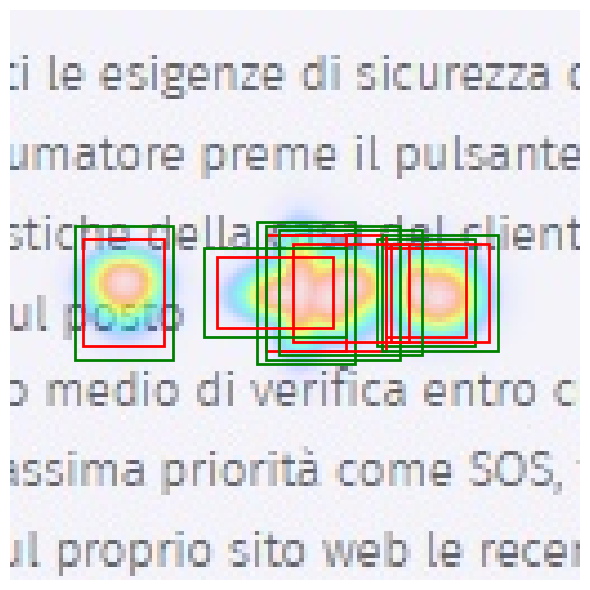

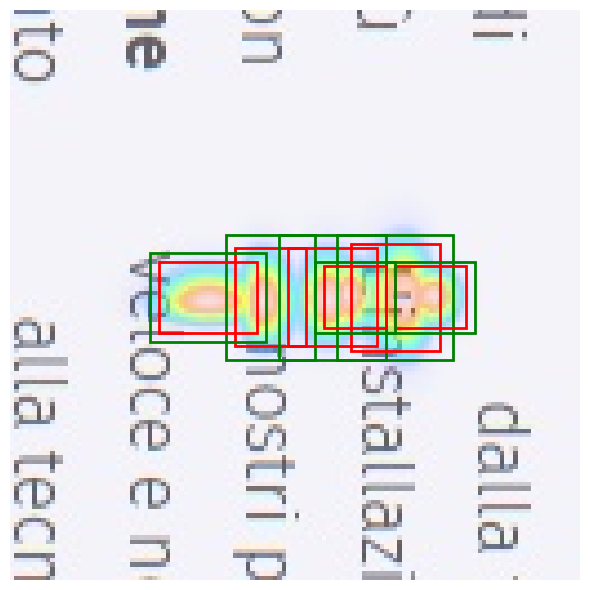

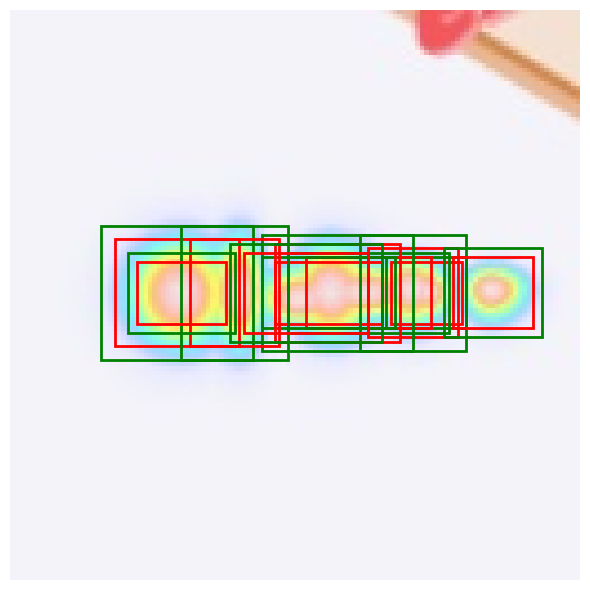

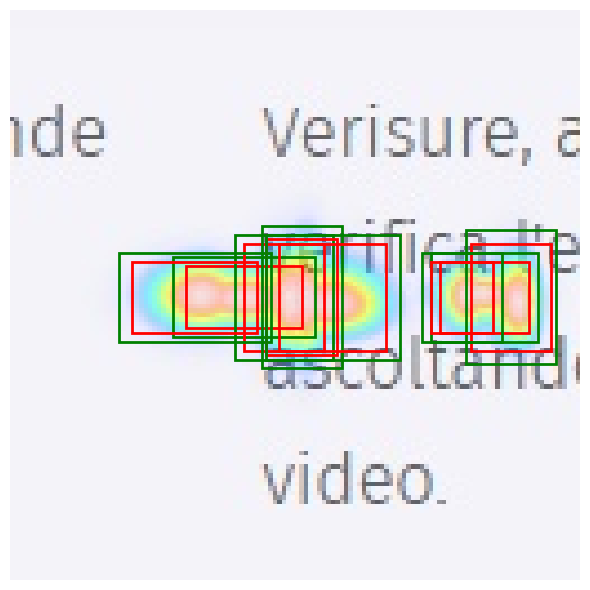

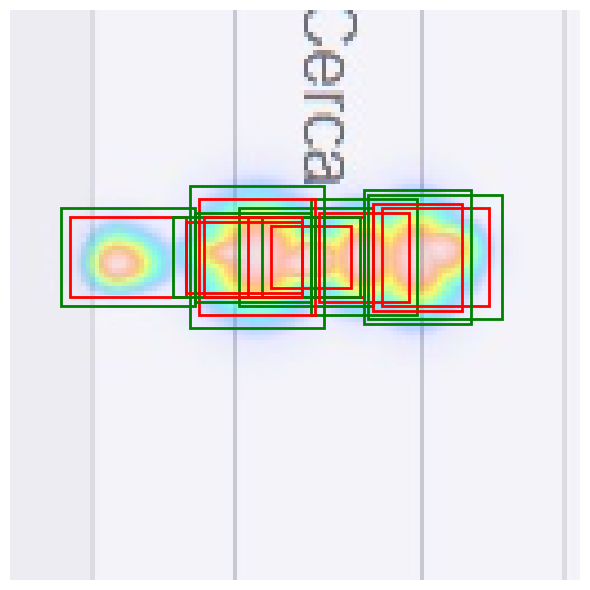

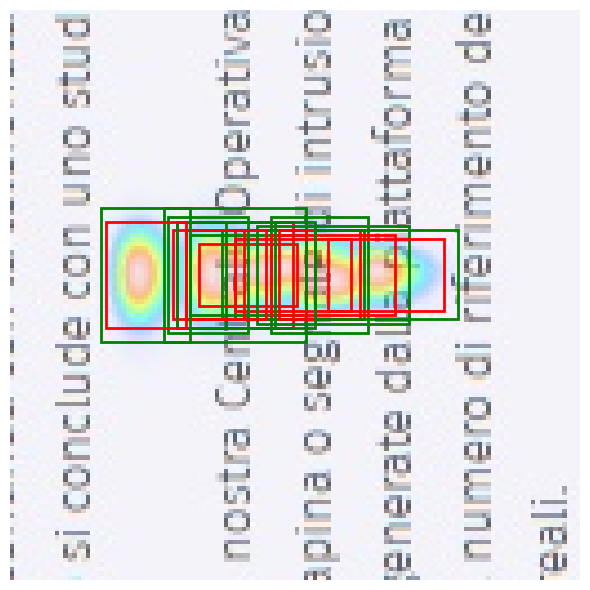

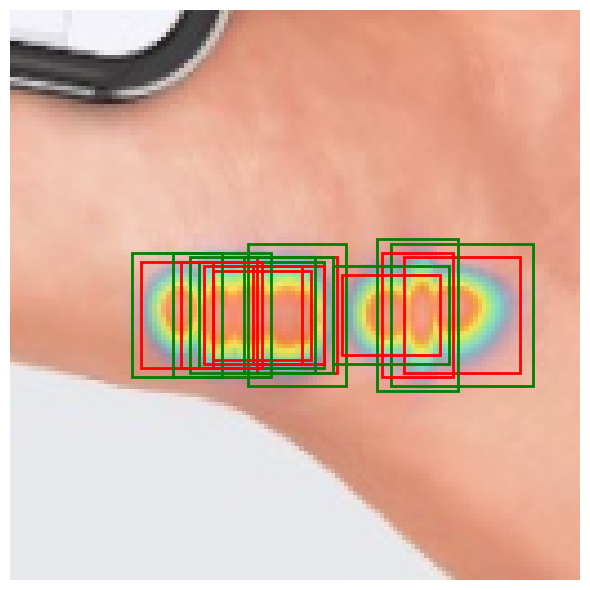

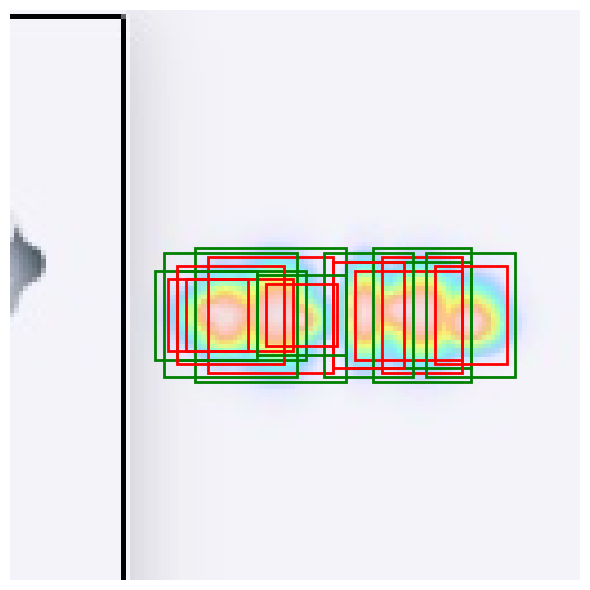

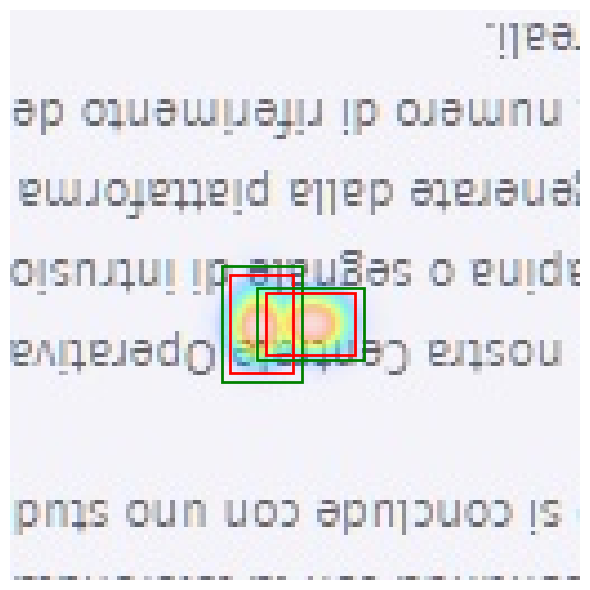

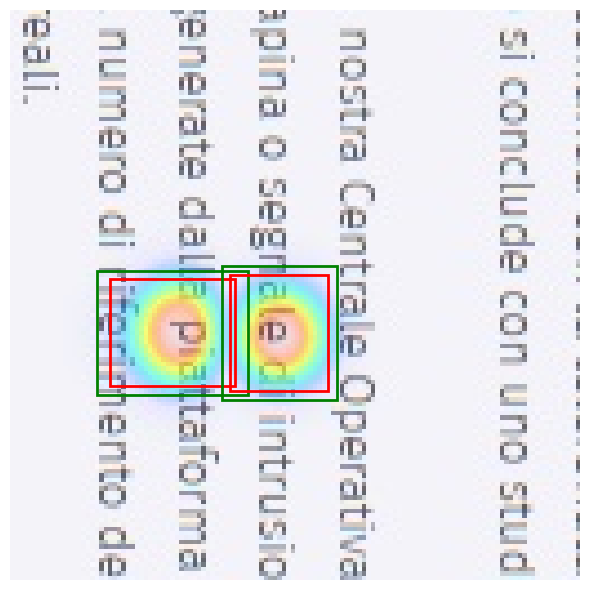

In [64]:
visualize_random_samples(os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR), num_samples=10)


In [46]:
# import os

# def get_folder_size(path):
#     total_size = 0
#     for dirpath, dirnames, filenames in os.walk(path):
#         for f in filenames:
#             fp = os.path.join(dirpath, f)
#             if os.path.exists(fp):
#                 total_size += os.path.getsize(fp)
#     return total_size

# folder_path = os.getcwd() + "/" +BlockingIOError OUTPUT_DIR
# size_bytes = get_folder_size(folder_path)
# print(f"Folder size: {size_bytes / (1024 * 1024):.2f} MB")


In [47]:
'''
import os

# Define the target directory
directory = 'data/hm_dataset_min_max/images'

# Get full paths of all files in the directory
all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Set batch size
batch_size = 100

# Loop through and delete files in batches
for i in range(0, len(all_files), batch_size):
    batch = all_files[i:i + batch_size]
    for file_path in batch:
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
    print(f"✅ Batch {i // batch_size + 1} completed.")
'''

'\nimport os\n\n# Define the target directory\ndirectory = \'data/hm_dataset_min_max/images\'\n\n# Get full paths of all files in the directory\nall_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]\n\n# Set batch size\nbatch_size = 100\n\n# Loop through and delete files in batches\nfor i in range(0, len(all_files), batch_size):\n    batch = all_files[i:i + batch_size]\n    for file_path in batch:\n        try:\n            os.remove(file_path)\n            print(f"Deleted: {file_path}")\n        except Exception as e:\n            print(f"Error deleting {file_path}: {e}")\n    print(f"✅ Batch {i // batch_size + 1} completed.")\n'

Chosen sigmas (σx, σy): (10.869408195643889, 9.682396919880048)


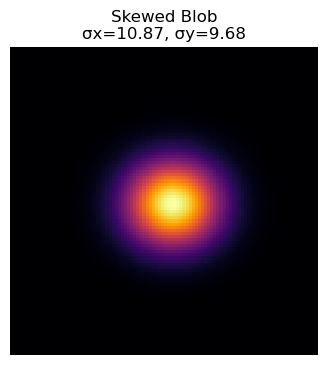

In [239]:
import numpy as np
import random
from scipy.stats import skewnorm

def generate_skewed_blob(image_size,
                         center,
                         sigma_x_range,
                         sigma_y_range,
                         alpha_x_range,
                         alpha_y_range):
    """
    Create a fully asymmetric (skewed) Gaussian-like blob and
    return it along with the selected sigmas.

    :param image_size: Tuple[int, int] (height, width) of the output image
    :param center: Tuple[int, int] (x, y) pixel coordinates of the blob center
    :param sigma_x_range: Tuple[float, float] range from which to pick σx
    :param sigma_y_range: Tuple[float, float] range from which to pick σy
    :param alpha_x_range: Tuple[float, float] range from which to pick αx (skew on x)
    :param alpha_y_range: Tuple[float, float] range from which to pick αy (skew on y)
    :return:
        blob: np.ndarray of shape (height, width), values in [0,1]
        sigma: Tuple[float, float] = (σx, σy)
    """
    h, w = image_size
    cx, cy = center

    # pick random scales and skews
    sigma_x = random.uniform(*sigma_x_range)
    sigma_y = random.uniform(*sigma_y_range)
    alpha_x = random.uniform(*alpha_x_range)
    alpha_y = random.uniform(*alpha_y_range)

    # build coordinate grid relative to center
    xs = np.arange(w) - cx
    ys = np.arange(h) - cy
    xv, yv = np.meshgrid(xs, ys)

    # normalize by chosen sigmas
    nx = xv / sigma_x
    ny = yv / sigma_y

    # skew-normal marginals
    fx = skewnorm.pdf(nx, a=alpha_x)
    fy = skewnorm.pdf(ny, a=alpha_y)

    # joint asymmetric blob
    blob = fx * fy

    # normalize to [0,1]
    if blob.max() > 0:
        blob /= blob.max()

    # return in the same style as the original function
    sigma = (sigma_x, sigma_y)
    return blob, sigma


# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # generate one blob
    blob, sigma = generate_skewed_blob(
        image_size=(100, 100),
        center=(50, 50),
        sigma_x_range=(3.0, 12.0),
        sigma_y_range=(3.0, 12.0),
        alpha_x_range=(-1.0, 1.0),
        alpha_y_range=(-1.0, 1.0)
    )

    print("Chosen sigmas (σx, σy):", sigma)

    # plot
    plt.figure(figsize=(4, 4))
    plt.imshow(blob, cmap="inferno")
    plt.title(f"Skewed Blob\nσx={sigma[0]:.2f}, σy={sigma[1]:.2f}")
    plt.axis("off")
    plt.show()
